In [11]:
!pip install yfinance ipywidgets matplotlib scipy seaborn


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns



In [13]:
# List of stock tickers
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'FB', 'NFLX', 'NVDA']

# Widgets for user interaction
selected_stocks = widgets.SelectMultiple(
    options=stock_tickers,
    value=['AAPL', 'MSFT', 'GOOGL', 'AMZN'],
    description='Stocks:',
    disabled=False
)

num_portfolios_slider = widgets.IntSlider(
    value=5000,
    min=1000,
    max=10000,
    step=1000,
    description='Num Portfolios:'
)

risk_free_rate_slider = widgets.FloatSlider(
    value=0.01,
    min=0.00,
    max=0.05,
    step=0.001,
    description='Risk-Free Rate:'
)

# Display the widgets
display(selected_stocks, num_portfolios_slider, risk_free_rate_slider)



SelectMultiple(description='Stocks:', index=(0, 1, 2, 3), options=('AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'F…

IntSlider(value=5000, description='Num Portfolios:', max=10000, min=1000, step=1000)

FloatSlider(value=0.01, description='Risk-Free Rate:', max=0.05, step=0.001)

In [14]:
def fetch_data(selected_stocks):
    # Fetch adjusted close prices for selected stocks
    data = yf.download(selected_stocks, start='2018-01-01', end='2023-01-01')['Adj Close']
    return data

# Fetch data for selected stocks
data = fetch_data(selected_stocks.value)

# Calculate daily returns
returns = data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = num_portfolios_slider.value
risk_free_rate = risk_free_rate_slider.value

# Display the first few rows of the returns
returns.head()



[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2018-01-03,-0.000175,0.012775,0.017061,0.004654
2018-01-04,0.004645,0.004476,0.003884,0.008801
2018-01-05,0.011385,0.016163,0.013260,0.012398
2018-01-08,-0.003714,0.014425,0.003531,0.001021
2018-01-09,-0.000115,0.004676,-0.001274,-0.000680


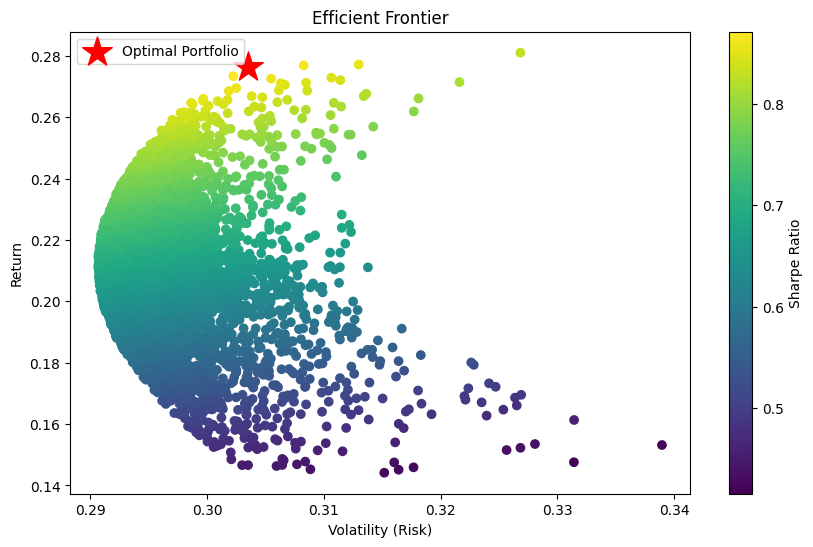

In [15]:
def calculate_portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_volatility = calculate_portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def simulate_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)

        portfolio_return, portfolio_volatility = calculate_portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_volatility
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility

    return results, weights_record

# Optimize portfolio
optimized_result = optimize_portfolio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimized_result.x

# Simulate random portfolios
results, weights_record = simulate_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Plotting the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(calculate_portfolio_performance(optimal_weights, mean_returns, cov_matrix)[1],
            calculate_portfolio_performance(optimal_weights, mean_returns, cov_matrix)[0], marker='*', color='r', s=500, label='Optimal Portfolio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.show()



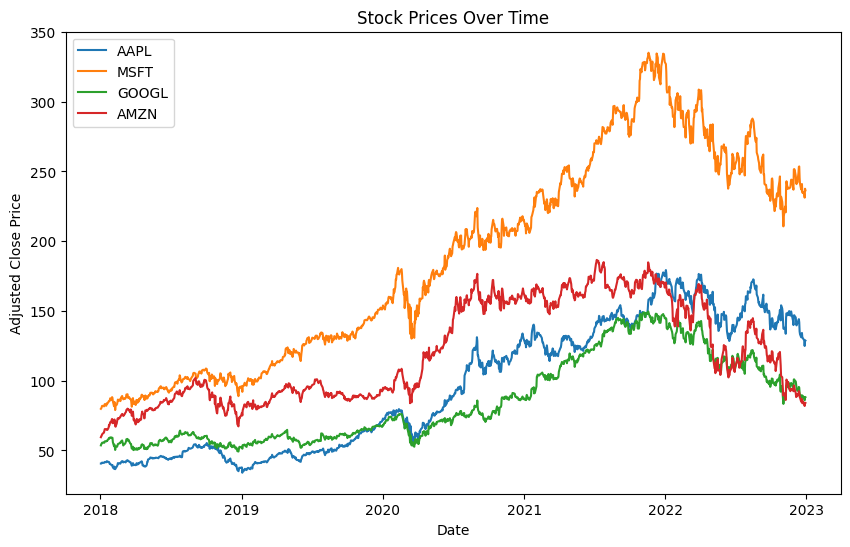

In [6]:
plt.figure(figsize=(10, 6))
for stock in selected_stocks.value:
    plt.plot(data[stock], label=stock)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()



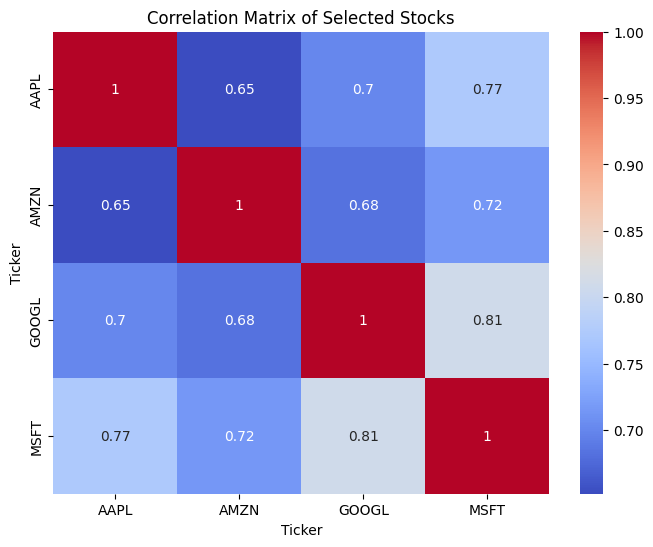

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Stocks')
plt.show()
